# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [5]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [25]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [6]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [7]:
## parsing data here
images, labels = parse_data(df)

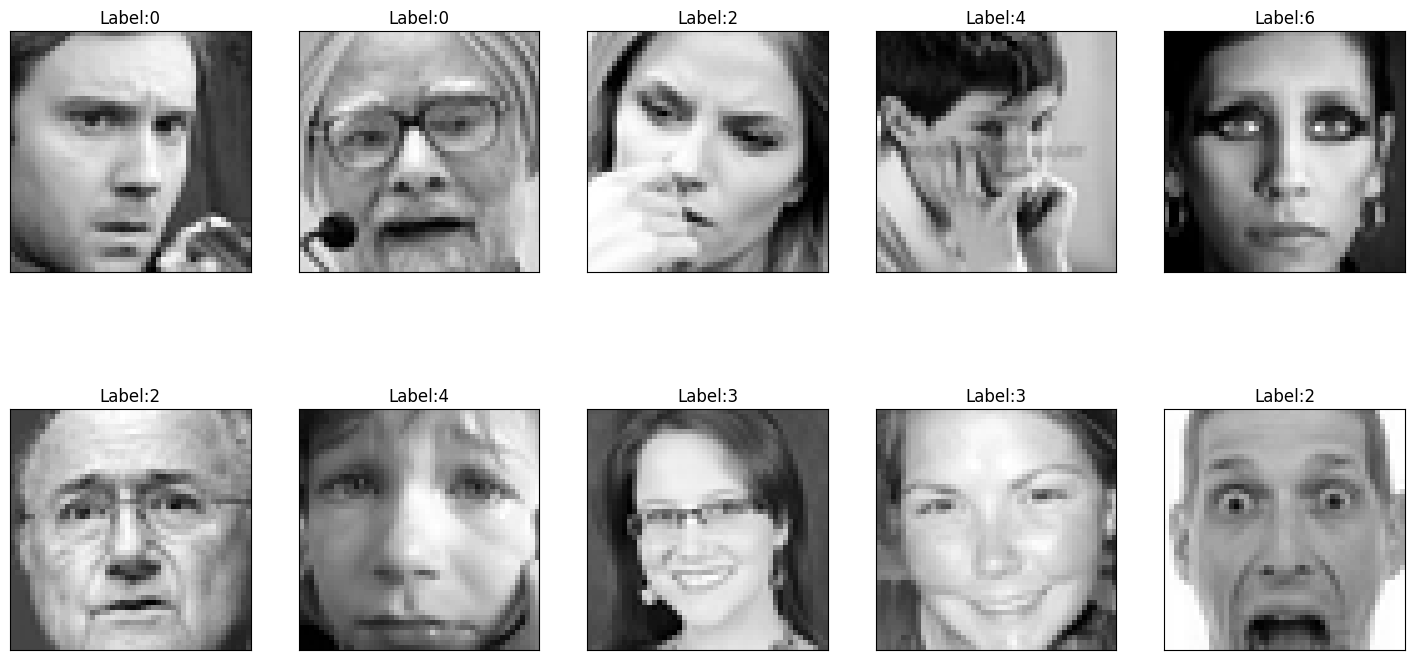

In [28]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [8]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
images_reshaped = images.reshape(images.shape[0], -1)
pca.fit(images_reshaped)
# pca.fit(images) ## modify images' array to the appropriate shape

PCA(n_components=2)

In [30]:
images.shape

(35887, 48, 48)

In [31]:
images_reshaped.shape

(35887, 2304)

In [32]:
## transform for visualizing here
images_pca=pca.transform(images_reshaped) ## modify images' array to the appropriate shape
images_pca.shape

(35887, 2)

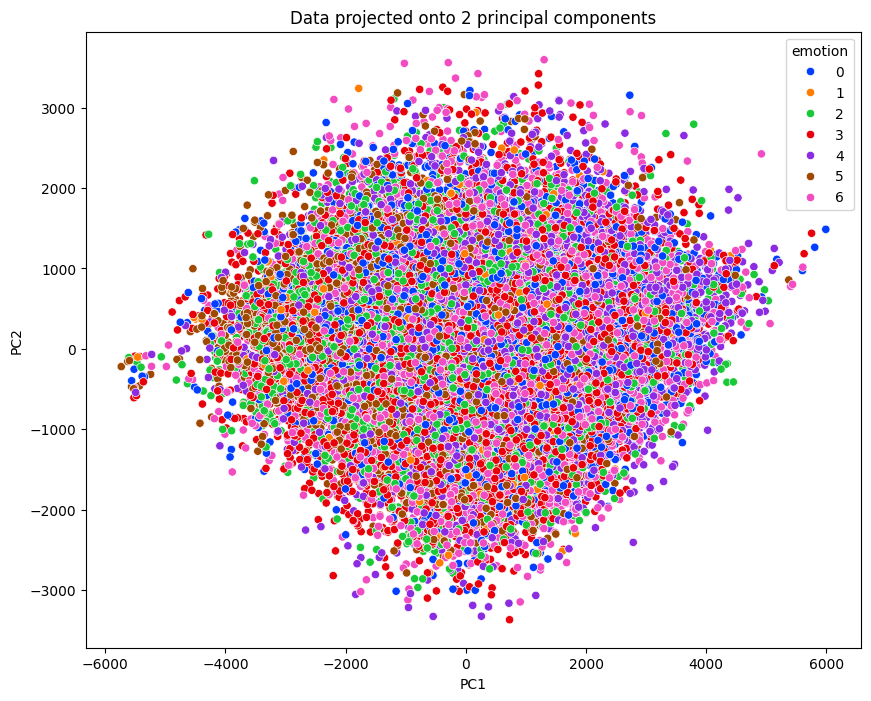

In [33]:
import seaborn as sns
df_pca = pd.DataFrame(data=images_pca, columns=['PC1', 'PC2'])
df_pca['emotion'] = labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='emotion', palette='bright')
plt.title('Data projected onto 2 principal components')
plt.show()

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

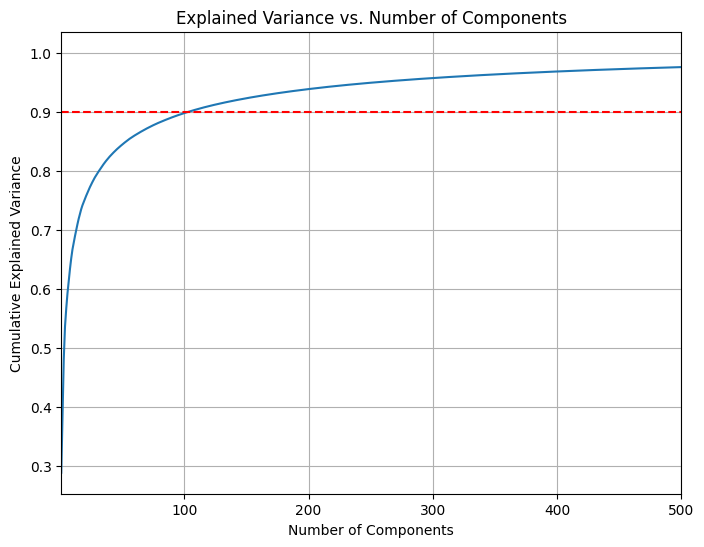

Số lượng principal components ở mức 95%: 104


In [34]:
pca = PCA()
pca.fit(images_reshaped)

explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)

# Chọn số lượng principal components dựa trên ngưỡng phương sai tích lũy
threshold_variance = 0.9 * cumulative_explained_variance[-1]  # 95% của tổng phương sai
n_components = np.argmax(cumulative_explained_variance >= threshold_variance) + 1

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.grid(visible=True)
plt.axhline(y=threshold_variance, color='r', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.xlim(1, 500)
plt.show()

print("Số lượng principal components ở mức 95%:", n_components)

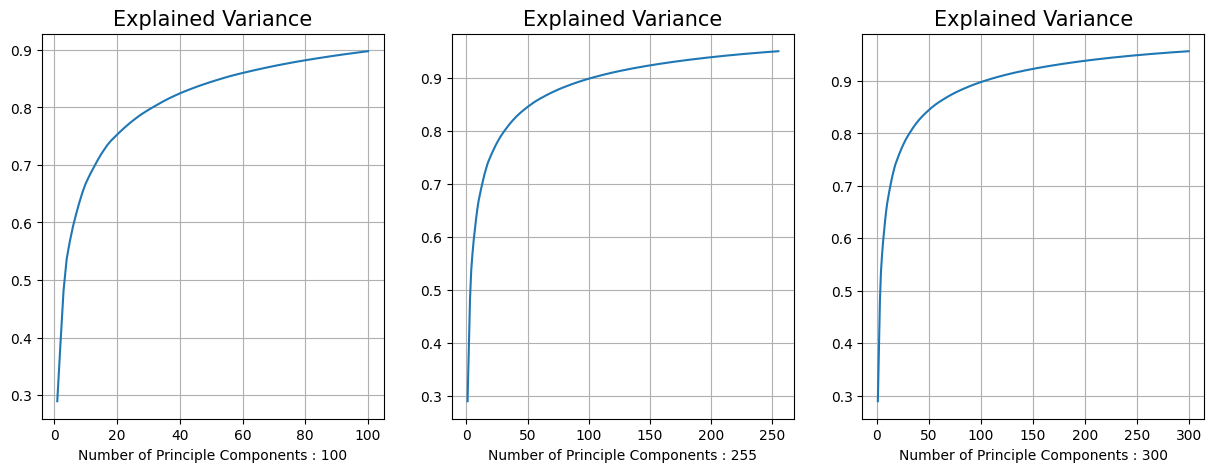

In [35]:
def EV(n):
    pca = PCA(n_components=n, whiten=True)
    # X_train = pca.fit_transform(x_train)
    # X_test = pca.transform(x_test)
    pca. fit(images_reshaped)
    #plot
    plt.plot(range(1,n+1), pca.explained_variance_ratio_.cumsum())
    plt.title('Explained Variance',fontsize=15)
    plt.grid(visible=True)
    plt.xlabel('Number of Principle Components : {}'.format(n), fontsize=10)
# use the function above and try use n_component=100,200,and 300
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
EV(100)
plt.subplot(1,3,2)
EV(255)
plt.subplot(1,3,3)
EV(300)

As shown above, if we compress the inputs data into 255 dimensions, we still can obtain the most information from inputs data.

Nếu ta nén dữ liệu input thành 255 chiều, ta vẫn có thể thu được nhiều thông tin nhất từ ​​input.

In [36]:
## determine the optimal number of PCs here
# pca.explained_variance_()

In [9]:
from sklearn.model_selection import train_test_split

X = images_reshaped
y = labels

RANDOM_STATE = 1111
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=104)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define logistic regression model
log_reg = LogisticRegression(max_iter=1000000)

# Define hyperparameters for grid search
param_grid= {
        'solver': ['lbfgs', 'liblinear','newton-cg', 'sag',],
        'penalty': ['l2']
    }

# grid search
grid_search = GridSearchCV(log_reg, param_grid, cv=3)

In [23]:
# Perform grid search on original data
grid_search.fit(X_train, y_train)
print("\nOriginal data - Logistic Regression")
print("Best Parameters: ",grid_search.best_params_)
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))


Original data - Logistic Regression
Best Parameters:  {'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.28      0.18      0.22      1458
           1       0.13      0.05      0.08       153
           2       0.23      0.17      0.19      1526
           3       0.47      0.64      0.54      2787
           4       0.29      0.28      0.28      1821
           5       0.47      0.48      0.47      1178
           6       0.33      0.33      0.33      1844

    accuracy                           0.37     10767
   macro avg       0.31      0.30      0.30     10767
weighted avg       0.35      0.37      0.36     10767



In [40]:
# Perform grid search on PCA transformed data
grid_search.fit(X_train_pca, y_train)
print("\nPCA data - Logistic Regression")
print("Best Parameters: ",grid_search.best_params_)
y_pred = grid_search.predict(X_test_pca)
print(classification_report(y_test, y_pred))


PCA data - Logistic Regression
Best Parameters:  {'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.29      0.14      0.19      1458
           1       0.13      0.01      0.02       153
           2       0.25      0.12      0.16      1526
           3       0.45      0.70      0.55      2787
           4       0.29      0.29      0.29      1821
           5       0.46      0.47      0.47      1178
           6       0.33      0.34      0.33      1844

    accuracy                           0.38     10767
   macro avg       0.31      0.30      0.29     10767
weighted avg       0.35      0.38      0.35     10767



## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
## visualize the confusion matrices and classification reports here